### <center> **Análise Preditiva:** Música

**Objetivo:** Prever a música que será a mais escutada ao final do ano. Retornar também as top 5 músicas.

In [ ]:
# Importações
import pandas as pd
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import warnings


In [243]:
warnings.filterwarnings('ignore')

In [250]:
# Lê o csv com o gênero das músicas
df = pd.read_csv('spotify_songs_sofia.csv')

### Compreensão dos Dados

In [251]:
df.info()
df.describe()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25997 entries, 0 to 25996
Data columns (total 24 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   ts                                 25997 non-null  object 
 1   platform                           25997 non-null  object 
 2   ms_played                          25997 non-null  int64  
 3   conn_country                       25997 non-null  object 
 4   ip_addr                            25997 non-null  object 
 5   master_metadata_track_name         25997 non-null  object 
 6   master_metadata_album_artist_name  25997 non-null  object 
 7   master_metadata_album_album_name   25965 non-null  object 
 8   spotify_track_uri                  25997 non-null  object 
 9   episode_name                       0 non-null      float64
 10  episode_show_name                  0 non-null      float64
 11  spotify_episode_uri                0 non-null      flo

,ts,platform,ms_played,conn_country,ip_addr,master_metadata_track_name,master_metadata_album_artist_name,master_metadata_album_album_name,spotify_track_uri,episode_name,...,audiobook_chapter_uri,audiobook_chapter_title,reason_start,reason_end,shuffle,skipped,offline,offline_timestamp,incognito_mode,genero
0,2023-04-04 18:25:30+00:00,android,11451,BR,177.76.148.44,Talk that Talk,TWICE,BETWEEN 1&2,spotify:track:0RDqNCRBGrSegk16Avfzuq,NaN,...,NaN,NaN,playbtn,endplay,False,True,False,1680632717,False,k-pop
1,2023-04-04 18:25:47+00:00,android,16559,BR,177.76.148.44,There's Nothing Holdin' Me Back,Shawn Mendes,Illuminate,spotify:track:7JJmb5XwzOO8jgpou264Ml,NaN,...,NaN,NaN,playbtn,endplay,False,True,False,1680632730,False,pop
2,2023-04-04 18:25:55+00:00,android,4168,BR,177.76.148.44,Woman,Doja Cat,Planet Her,spotify:track:6Uj1ctrBOjOas8xZXGqKk4,NaN,...,NaN,NaN,playbtn,endplay,False,True,False,1680632747,False,pop
3,2023-04-04 19:23:17+00:00,android,80840,BR,177.76.148.44,FLOWER,JISOO,ME,spotify:track:69CrOS7vEHIrhC2ILyEi0s,NaN,...,NaN,NaN,clickrow,logout,False,False,False,1680635513,False,k-pop
4,2023-04-04 22:51:39+00:00,android,67760,BR,201.42.207.140,FLOWER,JISOO,ME,spotify:track:69CrOS7vEHIrhC2ILyEi0s,NaN,...,NaN,NaN,appload,logout,False,False,False,1680647986,False,k-pop


### Preparação de Dados

In [252]:
# Colunas necessárias: ts, ms_played, master_metadata_track_name, master_metadata_album_artist_name, shuffle, skipped

# Copiando os dados para outro df
df_music = df[['ts', 'ms_played', 'master_metadata_track_name', 'master_metadata_album_artist_name', 'shuffle', 'skipped']].copy()

# apagando do df as músicas que foram puladas e estavam no modo aleatório
df_music.drop(
    df_music[(df_music['shuffle'] == True) & (df_music['skipped'] == True)].index, 
    inplace=True)

# Convertendo para timestamp
df_music['ts'] = pd.to_datetime(df['ts'])

# Criando colunas de mês
df_music['mes'] = df_music['ts'].dt.to_period('M')

# Convertendo ms_played para minutos
df_music['min_played'] = df_music['ms_played'] / 60000

# df limpo
display(df_music.head())

,ts,ms_played,master_metadata_track_name,master_metadata_album_artist_name,shuffle,skipped,mes,min_played
0,2023-04-04 18:25:30+00:00,11451,Talk that Talk,TWICE,False,True,2023-04,0.190850
1,2023-04-04 18:25:47+00:00,16559,There's Nothing Holdin' Me Back,Shawn Mendes,False,True,2023-04,0.275983
2,2023-04-04 18:25:55+00:00,4168,Woman,Doja Cat,False,True,2023-04,0.069467
3,2023-04-04 19:23:17+00:00,80840,FLOWER,JISOO,False,False,2023-04,1.347333
4,2023-04-04 22:51:39+00:00,67760,FLOWER,JISOO,False,False,2023-04,1.129333


In [253]:
# Agregação mensal por música e artista
df_month = (
    df_music.groupby(['mes', 'master_metadata_track_name', 'master_metadata_album_artist_name'])
      ['min_played'].sum()
      .reset_index()
)

df_month['mes'] = df_month['mes'].dt.to_timestamp()
df_month = df_month.sort_values('mes')

# Variável temporal ordinal (cada mês é um número)
min_mes = df_month['mes'].min()
df_month['mes_ord'] = (
    (df_month['mes'].dt.year - min_mes.year) * 12 +
    (df_month['mes'].dt.month - min_mes.month) + 1
)

# Próximo mês a prever
ultimo_mes_ord = df_month['mes_ord'].max()
proximo_mes_ord = ultimo_mes_ord + 1

display(df_month.head())
print(f"\nPróximo mês ordinal a prever: {proximo_mes_ord}")

,mes,master_metadata_track_name,master_metadata_album_artist_name,min_played,mes_ord
0,2023-04-01,34+35,Ariana Grande,2.895167,1
55,2023-04-01,Sour & Sweet,BamBam,0.139467,1
54,2023-04-01,Smoke Sprite (feat. RM of BTS),So!YoON!,3.719183,1
53,2023-04-01,Side To Side,Ariana Grande,3.769333,1
52,2023-04-01,Shut Down,BLACKPINK,8.794450,1



Próximo mês ordinal a prever: 35


### Modelo

In [258]:
resultados = []
avaliacoes = []

for musica in df_month['master_metadata_track_name'].unique():
    df_tmp = df_month[
        df_month['master_metadata_track_name'] == musica
    ][['mes_ord', 'min_played', 'master_metadata_album_artist_name']].copy()

    df_tmp = df_tmp.sort_values('mes_ord').dropna()

    # Pula músicas com histórico curto
    if len(df_tmp) < 3:
        continue

    artista = df_tmp['master_metadata_album_artist_name'].iloc[0]

    # Divisão de treino e teste
    n_test = 2
    train = df_tmp.iloc[:-n_test]
    test = df_tmp.iloc[-n_test:]

    X_train = train[['mes_ord']]
    y_train = train['min_played']
    X_test  = test[['mes_ord']]
    y_test  = test['min_played']

    # Modelo
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Previsão do teste
    y_pred = model.predict(X_test)

    # Avaliação
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    avaliacoes.append({'musica': musica, 'artista': artista, 'MAE': mae, 'RMSE': rmse, 'R2': r2})

    # Previsão do próximo mês
    previsao = model.predict([[proximo_mes_ord]])[0]
    previsao = max(previsao, 0) 

    resultados.append({'musica': musica, 'artista': artista,'previsao_minutos': previsao})

print(f"Modelos treinados para {len(resultados)} músicas.")

Modelos treinados para 1154 músicas.


### Resultado das Avaliações

In [259]:
df_avaliacao = pd.DataFrame(avaliacoes).sort_values('MAE')
print("10 gêneros com menor erro de previsão (MAE):")
print(df_avaliacao.head(10).to_string(index=False))

10 gêneros com menor erro de previsão (MAE):
                musica             artista     MAE     RMSE   R2
     YAD - Slowed Down      Vanna Rainelle 0.00000 0.000000  1.0
         Trem Das Onze    Adoniran Barbosa 0.00000 0.000000  1.0
                Scream             ENHYPEN 0.00000 0.000000  1.0
                Dinero    Trinidad Cardona 0.00000 0.000000  1.0
             Blue Hour TOMORROW X TOGETHER 0.00000 0.000000  1.0
            Impurities         LE SSERAFIM 0.00000 0.000000  1.0
       Do It Like This           P1Harmony 0.00000 0.000000  1.0
                   pov       Ariana Grande 0.00000 0.000000  1.0
              12345SEX              UPSAHL 0.00005 0.000071 -1.0
you should know better      Vanna Rainelle 0.00116 0.001172  0.0


### Resultado do Modelo (Previsão)

In [263]:
df_result = pd.DataFrame(resultados, columns=['musica', 'artista', 'previsao_minutos'])
top5 = df_result.sort_values('previsao_minutos', ascending=False).head(5)

musica = top5.iloc[0]['musica']
artista = top5.iloc[0]['artista']
minutos = top5.iloc[0]['previsao_minutos']

print(f"Música prevista para o próximo mês: '{musica}' — {artista}")
print(f"Previsão de minutos: {minutos:.2f} min\n")
print("5 músicas previstas:")
print(top5.to_string(index=False))

Música prevista para o próximo mês: 'Your Idol' — Saja Boys
Previsão de minutos: 355.92 min

5 músicas previstas:
                     musica    artista  previsao_minutos
                  Your Idol  Saja Boys        355.915433
Posso Até Não Te Dar Flores DJ Japa NK        269.136017
       she's all i wanna be Tate McRae        238.358117
               Supostamente Bea Duarte        158.955433
                      uh oh Tate McRae        153.141500


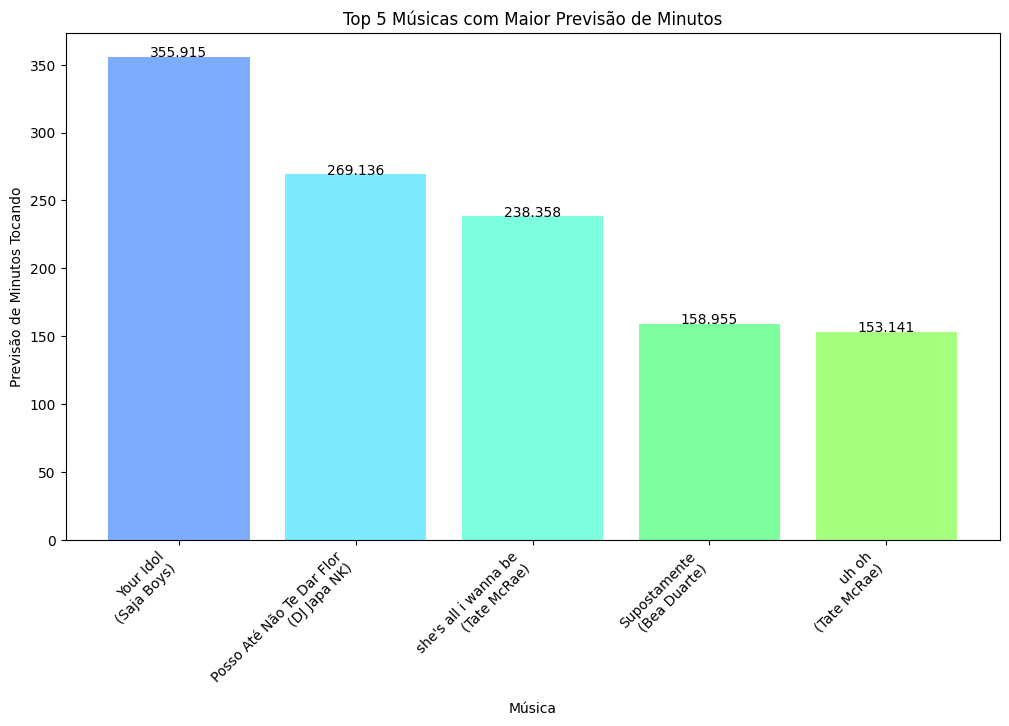

In [269]:
# Gráfico
plt.figure(figsize=(10, 6))

cores = ['#7DACFF', '#7DEBFF', '#7DFFDF', '#7DFF9E', '#A6FF7D']
labels = [f"{row['musica'][:25]}\n({row['artista'][:20]})" for _, row in top5.iterrows()]

plt.bar(labels, top5['previsao_minutos'], color=cores)
plt.title('Top 5 Músicas com Maior Previsão de Minutos')

for i, v in enumerate(top5['previsao_minutos']):
    plt.text(i, v, f"{v:.3f}", ha='center')

plt.tight_layout()

plt.xlabel('Música')
plt.ylabel('Previsão de Minutos Tocando')
plt.xticks(rotation=45, ha='right')
plt.show()

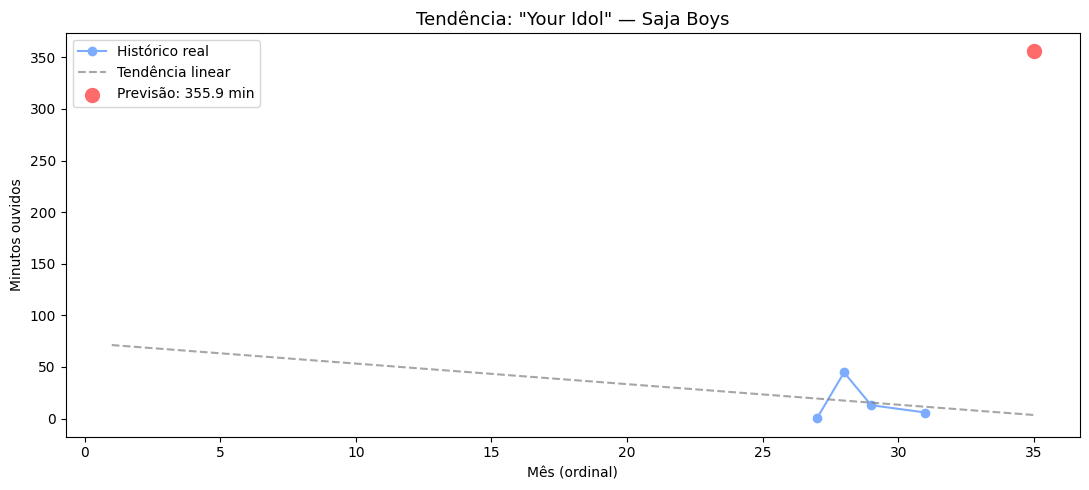

In [268]:
df_v = df_month[df_month['master_metadata_track_name'] == musica][['mes_ord', 'min_played']].sort_values('mes_ord')

model_v = LinearRegression().fit(df_v[['mes_ord']], df_v['min_played'])
x_plot = np.arange(1, proximo_mes_ord + 1).reshape(-1, 1)
y_plot = np.clip(model_v.predict(x_plot), 0, None)

plt.figure(figsize=(11, 5))
plt.plot(df_v['mes_ord'], df_v['min_played'], 'o-', label='Histórico real', color='#7DACFF')
plt.plot(x_plot, y_plot, '--', label='Tendência linear', color='gray', alpha=0.7)
plt.scatter([proximo_mes_ord], [minutos], color='#FF6B6B', zorder=5,
            s=100, label=f'Previsão: {minutos:.1f} min')
plt.title(f'Tendência: "{musica}" — {artista}', fontsize=13)
plt.xlabel('Mês (ordinal)')
plt.ylabel('Minutos ouvidos')
plt.legend()
plt.tight_layout()
plt.show()